# **Importación de paquetes**

In [1]:
#Importación de paquetes
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV,KFold
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from scipy.stats.distributions import uniform
from Machine_Learning_Tools.plots import *
from Machine_Learning_Tools.models import *
from sklearn.decomposition import PCA
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

# **Análsis del dataset**

In [2]:
df = pd.read_csv('datasets/insurance.csv')
# Imprimimos los primeros 5 elementos del dataset
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Revisamos la información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


El dataset no contiene datos nulos, tiene 6 variables; 2 de tipo float, 2 de tipo int y 3 de tipo object, además  de tener  1338 renglones.

In [4]:
# Descripción de las variables númericas
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# **Análisis descriptivo**

In [6]:
# Dividimos las variables en númericas y categóricas
numeric_features = ['age','bmi','charges']

categorical_features = ['sex','smoker','region','children']

Se utilizará la variable ''children'' como categórica, el valor máximo que toma esta variable es de 5, por tanto los valores mayores o iguales a este, se tomara como la categoría de 5 o más hijos.

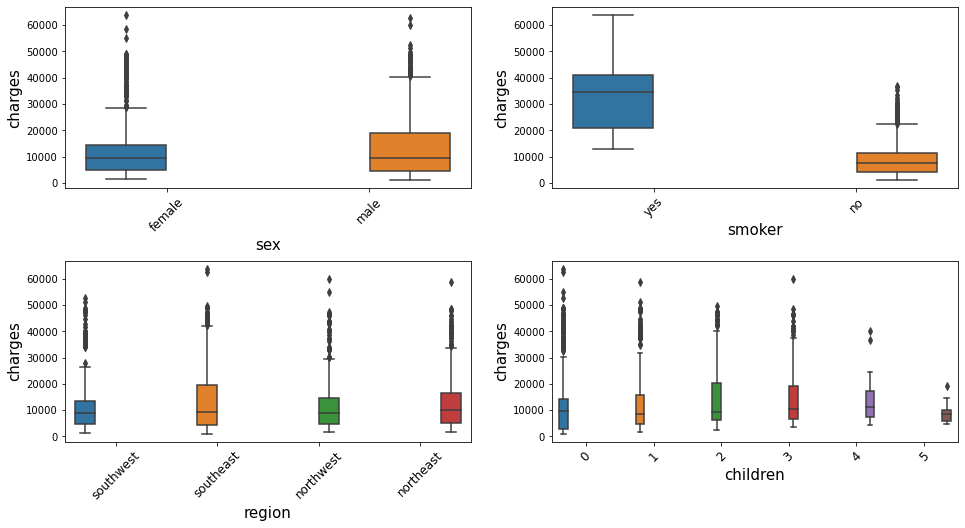

In [10]:
# Boxplot de las variable charges para cada una de las categorias de las variables, sex, smoker , region  y children
boxplot1(df,'charges',categorical_features,figsize=(16,8),label_size=15,xticks_size=12)

Del gráfico anterior, podemos deducir lo siguiente:

- La densidad de la variable charges tiene una moda, un mínimo y un máximo parecidos en ambas categorías de la variable sex,  aunque el valor del percentil  75 es mayor para la  categoría male, pero en general no se ve una diferencia clara en las densidades

- La densidad de la variable charges

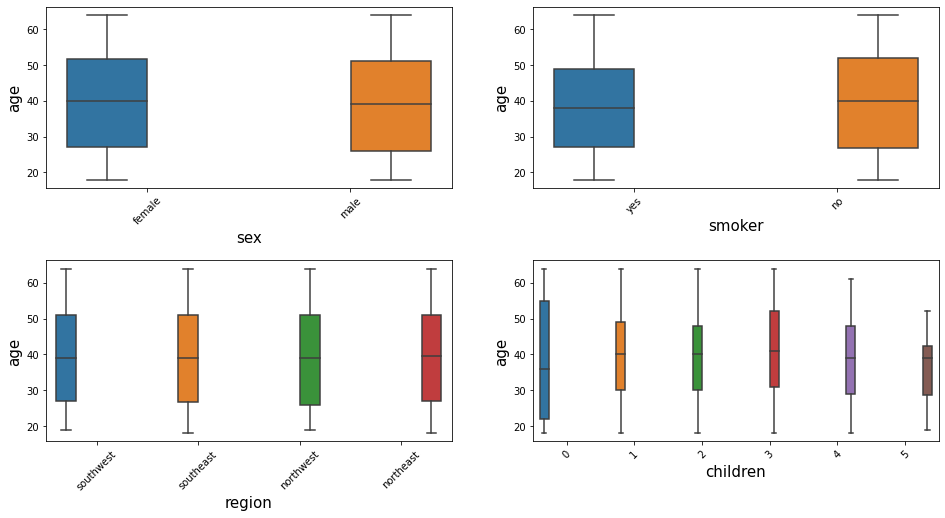

In [12]:
boxplot1(df,'age',categorical_features,figsize=(16,8))

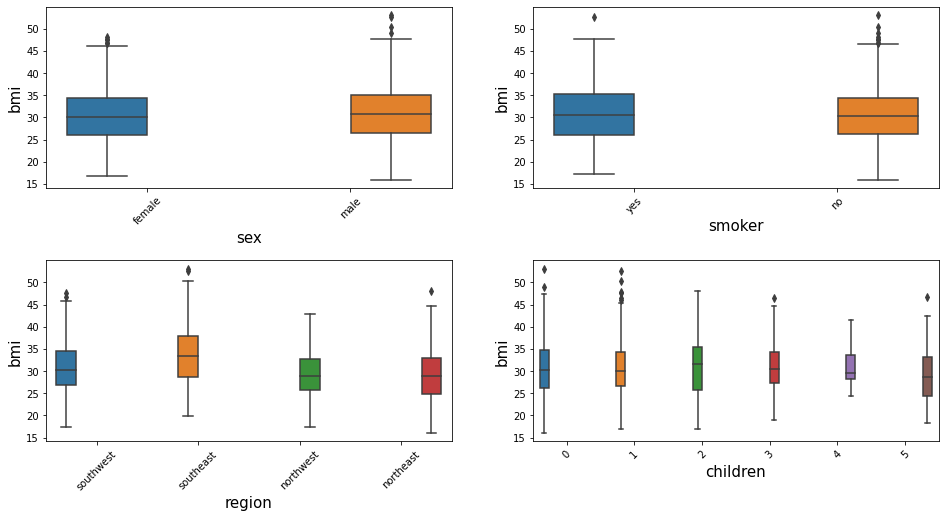

In [13]:
boxplot1(df,'bmi',categorical_features,figsize=(16,8))

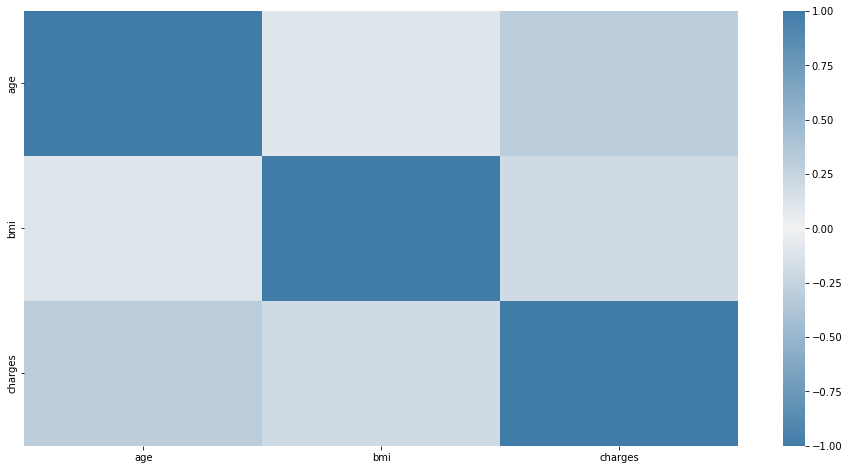

In [14]:
correlogram(df,numeric_features,figsize=(16,8))

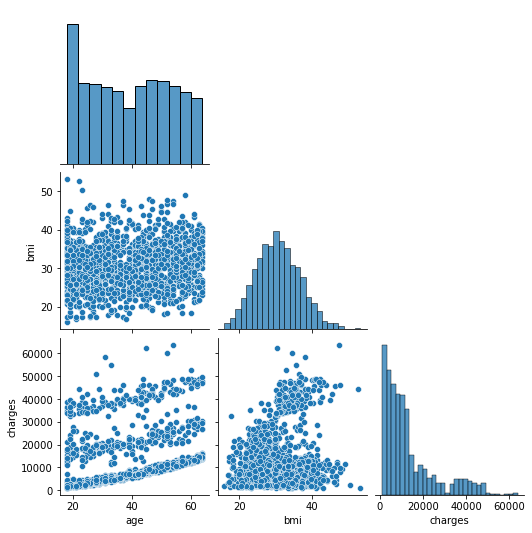

In [15]:
pairplot(df,numeric_features)

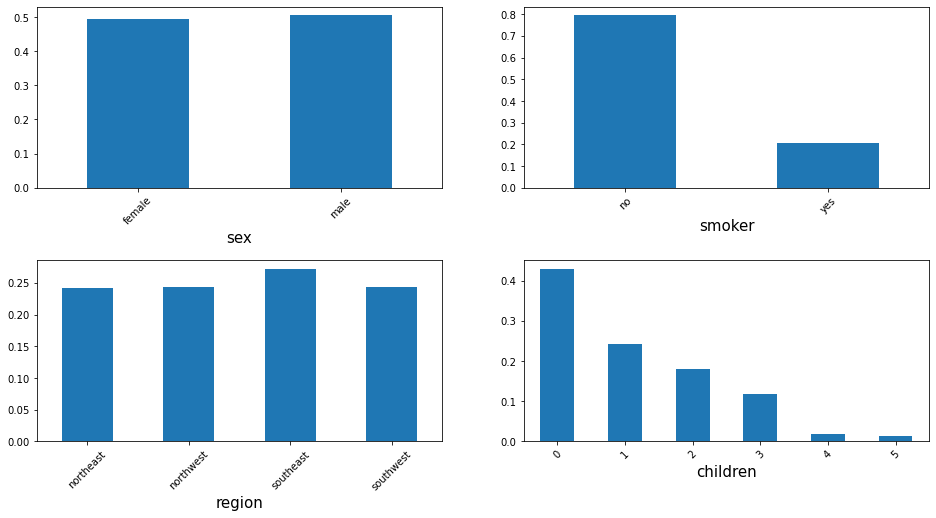

In [16]:
barplot(df,categorical_features,figsize=(16,8))

In [86]:
df['charges10K'] = df.charges/10000

In [87]:
features = df.columns[(df.columns!='charges') & (df.columns!='charges10K')]

target = ['charges10K'] 

In [99]:
scaler = MinMaxScaler()

encoder = OneHotEncoder(drop='first')

features_transformer = ColumnTransformer([
    ('numeric',scaler,numeric_features[:-1]),
    ('categorical',encoder,categorical_features)
])

#features_transformer.fit(X)

model_sel = RandomForestRegressor()

feature_selector = SelectFromModel(estimator=model_sel)

lr = SVR()

params = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],'degree':[1,2,3,4],'coef0':uniform(),'tol':uniform(),
         'epsilon':uniform()}

In [100]:
lr_model = Supervised_Model(df,features,target,lr,'linear_regression')
lr_model.add_column_transformer(features_transformer)
lr_model.add_feature_selector(feature_selector)
lr_model.X.head()

/home/yaelo1997/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_from_model.py:351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)


,numeric__age,numeric__bmi,categorical__smoker_yes
0,0.021739,0.321227,1.0
1,0.000000,0.479150,0.0
2,0.217391,0.458434,0.0
3,0.326087,0.181464,0.0
4,0.304348,0.347592,0.0


In [101]:
lr_model.cross_val_score(mean_squared_error)

/home/yaelo1997/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yaelo1997/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yaelo1997/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yaelo1997/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

In [102]:
lr_model.cv_score.mean()

train    0.234010
test     0.237376
dtype: float64

In [104]:
lr_model.cv_hyperparameter_tuning(params,10,'neg_mean_absolute_error',seed=1)

/home/yaelo1997/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yaelo1997/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yaelo1997/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/yaelo1997/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

In [105]:
lr_model.best_params

{'coef0': 0.20445224973151743,
 'degree': 3,
 'epsilon': 0.22957721372982554,
 'kernel': 'rbf',
 'tol': 0.6704675101784022}

In [106]:
lr_model.best_score

-0.2954511578921786

In [25]:
rscv_results.best_score_

-0.37221235021484017

In [26]:
rscv_results.best_estimator_.coef_

array([ 1.13649574,  1.05418295, -0.00361546,  2.31653418, -0.02698555,
       -0.06514996, -0.07425291,  0.02455939,  0.15011574,  0.08538622,
        0.20747574,  0.02651106])

In [110]:
mse_cv = cross_val_score(linear_reg,X_best,y,mean_squared_error,seed=100)
mse_cv.mean()

0.3748163758134334

In [27]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X,y)

DecisionTreeRegressor()

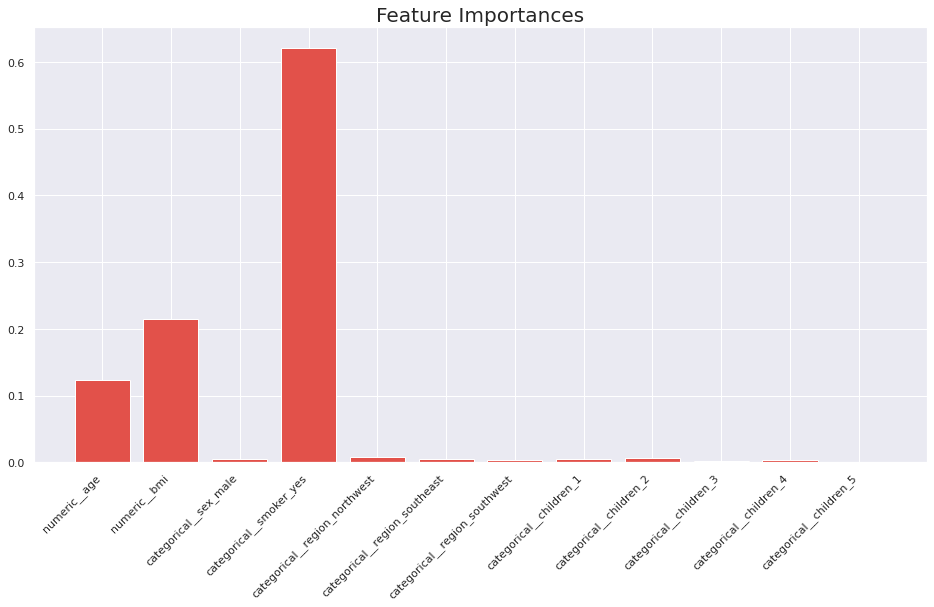

In [41]:
plt.figure(figsize=(16,8))
plt.bar(x=features_transformer.get_feature_names_out(),height=tree_model.feature_importances_)
plt.xticks(rotation=45,ha='right')
plt.title('Feature Importances',fontsize=20)
plt.show()

In [42]:
X_MIF = X[:,tree_model.feature_importances_>0.1]

(1338, 3)

In [43]:
linear_reg = LinearRegression()

linear_reg.fit(X_MIF,y)

linear_reg.coef_

MIF = features_transformer.get_feature_names_out()[tree_model.feature_importances_>0.1]
coefs = pd.DataFrame(linear_reg.coef_,index=MIF,columns=['Coef'])

coefs

,Coef
numeric__age,1.193918
numeric__bmi,1.199160
categorical__smoker_yes,2.382368


In [47]:
mse_cv = cross_val_score(linear_reg,X_MIF,y,mean_squared_error,seed=2500)
mse_cv.mean()

0.3724430669952316

In [54]:
rscv_results.best_estimator_.predict(X)[:10]*10000

array([25143.34833298,  3696.20897368,  6556.73954148,  4400.06529569,
        5904.30036805,  4421.2073174 , 10556.57205392,  7706.32181797,
        9180.06535969, 11996.07700683])